In [1]:
import tensorflow as tf
import PIL
import matplotlib.pyplot as plt

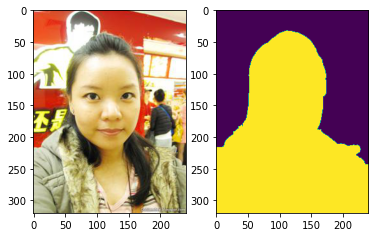

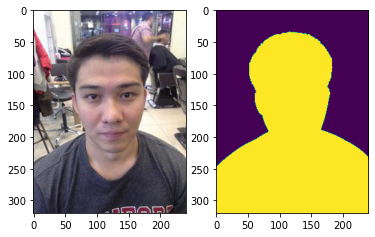

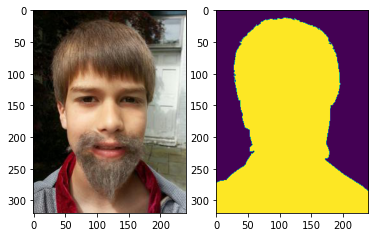

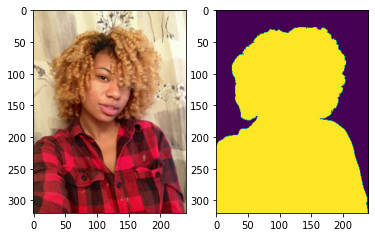

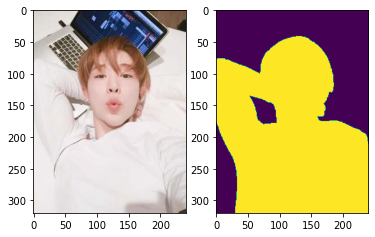

In [2]:
for i in range(5):
    fig, ax = plt.subplots(1,2)
    img = PIL.Image.open(f'./data/train/{i}.jpg')
    mask = PIL.Image.open(f'./data/train_mask/{i}.png')
    ax[0].imshow(img)
    ax[1].imshow(mask)
    plt.show()

In [3]:
img = PIL.Image.open('./data/train/0.jpg')
mask = PIL.Image.open('./data/train_mask/0.png')
print(img.size)
print(mask.size)

(240, 320)
(240, 320)


In [4]:
train_path = "./data/train/*.jpg"
valid_path = "./data/valid/*.jpg"

In [5]:
train_img_ds = tf.data.Dataset.list_files(train_path, shuffle=False)
valid_img_ds = tf.data.Dataset.list_files(valid_path, shuffle=False)

2022-02-24 00:40:46.337581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 00:40:46.364733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 00:40:46.364883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 00:40:46.365613: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
def preprocess_train(file_path):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    mask_path = tf.strings.regex_replace(file_path,"train", "train_mask")
    mask_path = tf.strings.regex_replace(mask_path,"jpg", "png")
    mask = tf.io.read_file(mask_path)
    mask = tf.io.decode_jpeg(mask, channels=3)
    return file_path, mask_path

In [7]:
def preprocess_valid(file_path):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    mask_path = tf.strings.regex_replace(file_path,"valid", "valid_mask")
    mask_path = tf.strings.regex_replace(mask_path,"jpg", "png")
    mask = tf.io.read_file(mask_path)
    mask = tf.io.decode_jpeg(mask, channels=3)
    return img, mask

In [8]:
train_ds = train_img_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
validation_ds = valid_img_ds.map(preprocess_valid, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
train_ds = train_ds.batch(32).prefetch(1)
validation_ds = validation_ds.batch(32).prefetch(1)

In [10]:
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Concatenate, Activation, UpSampling2D, Conv2D, MaxPooling2D

In [17]:
input_layer = Input(shape=(240, 320, 3))
#
conv_1_1 = Conv2D(32, (3, 3), padding='same')(input_layer)
conv_1_1 = Activation('relu')(conv_1_1)
conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)
pool_1 = MaxPooling2D(2)(conv_1_2)
#
conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)
conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)
pool_2 = MaxPooling2D(2)(conv_2_2)
#
conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)
conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)
pool_3 = MaxPooling2D(2)(conv_3_2)
#
conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)
conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)
pool_4 = MaxPooling2D(2)(conv_4_2)
#
#
up_1 = UpSampling2D(2, interpolation='bilinear')(pool_4)
conc_1 = Concatenate()([conv_4_2, up_1])
conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)
#
up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_1)
conc_2 = Concatenate()([conv_3_2, up_2])
conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(conc_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)
#
up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_1)
conc_3 = Concatenate()([conv_2_2, up_3])
conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(conc_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)
#
up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_1)
conc_4 = Concatenate()([conv_1_2, up_4])
conv_up_4_1 = Conv2D(32, (3, 3), padding='same')(conc_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)
#
conv_up_out = Conv2D(1, (3, 3), padding='same')(conv_up_4_1)
output_layer = Activation('sigmoid')(conv_up_out)

model = Model(inputs=input_layer, outputs=output_layer)

In [20]:
conv_up_out

<KerasTensor: shape=(None, 240, 320, 1) dtype=float32 (created by layer 'conv2d_25')>

In [18]:
model.compile(
    keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), 
    'binary_crossentropy', metrics=['accuracy']
    )

In [19]:
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=40
)

Epoch 1/40


ValueError: in user code:

    File "/home/ivan/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/home/ivan/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ivan/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/home/ivan/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/home/ivan/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/ivan/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py", line 227, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "model_1" (type Functional).
    
    Input 0 of layer "conv2d_13" is incompatible with the layer: expected min_ndim=4, found ndim=1. Full shape received: (None,)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None,), dtype=string)
      • training=True
      • mask=None
